<a href="https://colab.research.google.com/github/yanishalloum/liver_tumor_classification/blob/main/liver_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 ! pip install -q kaggle

In [ ]:
 from google.colab import files
 files.upload()

Saving kaggle(1).json to kaggle(1).json


{'kaggle(1).json': b'{"username":"yanis13","key":"9074a470eed5300cd3e518ebc6b08c22"}'}

In [ ]:
! rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download andrewmvd/liver-tumor-segmentation

100% 4.82G/4.84G [00:55<00:00, 178MB/s]
100% 4.84G/4.84G [00:56<00:00, 92.7MB/s]


In [ ]:
! unzip liver-tumor-segmentation.zip -d segmentation_part1


In [ ]:
rm -r liver-tumor-segmentation.zip

In [ ]:
#! kaggle datasets download andrewmvd/liver-tumor-segmentation-part-2

100% 10.8G/10.8G [08:58<00:00, 23.2MB/s]
100% 10.8G/10.8G [08:58<00:00, 21.5MB/s]


In [ ]:
#! unzip liver-tumor-segmentation-part-2.zip -d segmentation_part2

In [ ]:
! mv segmentation_part1/segmentations ./segmentations

! mv segmentation_part1/volume_pt1 ./volume
! mv segmentation_part1/volume_pt2 ./volume
! mv segmentation_part1/volume_pt3 ./volume
! mv segmentation_part1/volume_pt4 ./volume
! mv segmentation_part1/volume_pt5 ./volume

In [ ]:
rm -r segmentation_part1/

In [ ]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from fastai.vision.all import *
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.notebook import tqdm
import csv

In [ ]:
# Stock data in dataframe

list = []
for directory, _, files in os.walk('./segmentations'):
    for file in files:
        list.append((directory, file))

for directory, _, files in os.walk('./volume'):
    for file in files:
        list.append((directory, file))

df = pd.DataFrame(list, columns = ['directory', 'file'])
df.sort_values(by = ['file'], ascending=True)

,directory,file
110,./segmentations,segmentation-0.nii
93,./segmentations,segmentation-1.nii
77,./segmentations,segmentation-10.nii
87,./segmentations,segmentation-100.nii
51,./segmentations,segmentation-101.nii
...,...,...
172,./volume/volume_pt5,volume-50.nii
161,./volume/volume_pt1,volume-6.nii
171,./volume/volume_pt1,volume-7.nii
163,./volume/volume_pt1,volume-8.nii


In [ ]:
# Pair up the volume scan with its segmentation mask
df["mask_directory"] = ""
df["mask_file"] = ""

for i in range(131):
    scan, mask = f"volume-{i}.nii", f"segmentation-{i}.nii"

    df.loc[df['file'] == scan, 'mask_file'] = mask
    df.loc[df['file'] == scan, 'mask_directory'] = "./segmentations"

# Erase the unmatched scans and duplicates
df = df[df.mask_file != ''].sort_values(by = ['file']).reset_index(drop = True)

In [ ]:
# Read nii files
def read_nii(file_path):
    """
    Load, extract and apply a 90 degrees rotation
    (the raw data is flipped) to the NIfTI file
    found at the filepath
    """
    scan = nib.load(file_path)
    data = np.rot90(np.array(scan.get_fdata()))
    return data

In [ ]:
# Classification functions

# Checks if the scan contains the liver or not
def is_empty(mask_image):
    return int (not (1 in mask_image))

# Checks if the liver is sane or not
def is_tumor(mask_image):
    return int((2 in mask_image))

In [ ]:
#TWIMLfest: Fundamentals of Medical Image Processing for Deep Learning, Sam Charrington

# Window the images so that the liver is more visible
def apply_windowing(image, level, width):
    windowed_image = image.copy()
    min = level - width // 2
    max = level + width // 2

    windowed_image[windowed_image < min] = min
    windowed_image[windowed_image > max] = max

    return windowed_image

#https://radiopaedia.org/articles/windowing-ct?lang=us
liver_level = 30
liver_width = 150

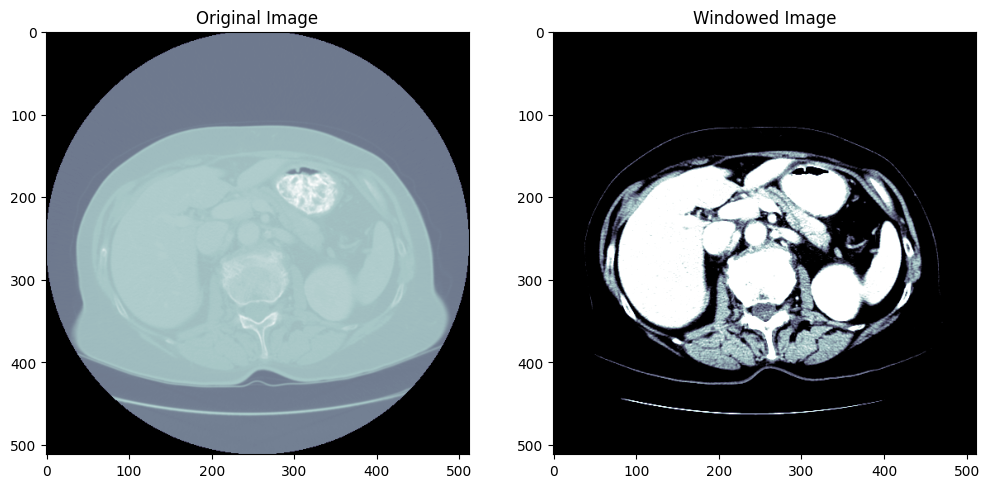

In [ ]:
# Plotting some sample
idx = 0
nii_sample = read_nii(df.loc[idx, 'directory'] + "/" + df.loc[idx, 'file'])
sample_mask = read_nii(df.loc[idx, 'mask_directory'] + "/" + df.loc[idx, 'mask_file'])

scan_sample = nii_sample[..., 55].astype(np.float32)

scan_sample_windowed = apply_windowing(scan_sample, liver_level, liver_width)

# Create a 1x2 grid for plotting
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Plot the original image
ax0 = plt.subplot(gs[0])
ax0.imshow(scan_sample, cmap = plt.cm.bone)
ax0.set_title('Original Image')

# Plot the windowed image
ax1 = plt.subplot(gs[1])
ax1.imshow(scan_sample_windowed, cmap=plt.cm.bone)
ax1.set_title('Windowed Image')

plt.show()

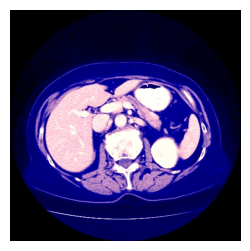

In [ ]:
#TWIMLfest: Fundamentals of Medical Image Processing for Deep Learning, Sam Charrington

# Window the images so that the liver is more visible

#https://radiopaedia.org/articles/windowing-ct?lang=us
dicom_windows = types.SimpleNamespace(liver=(150,30), custom = (200,60))

idx = 0
sample_scan = read_nii(df.loc[idx,'directory']+"/"+df.loc[idx,'file'])
sample_mask = read_nii(df.loc[idx,'mask_directory']+"/"+df.loc[idx,'mask_file'])

idx = 55
sample_slice = tensor(sample_scan[...,idx].astype(np.float32))

class TensorScan(TensorImageBW):

    def windowed(self: Tensor, w, l):
        px = self.clone()
        px_min = l - w // 2
        px_max = l + w // 2
        px[px < px_min] = px_min
        px[px > px_max] = px_max
        return (px - px_min) / (px_max - px_min)

    def freqhist_bins(self: Tensor, n_bins=100):
        imsd = self.view(-1).sort()[0]
        t = torch.cat([tensor([0.001]),
                       torch.arange(n_bins).float() / n_bins + (1 / 2 / n_bins),
                       tensor([0.999])])
        t = (len(imsd) * t).long()
        return imsd[t].unique()

    def normalize(self: Tensor, brks=None):
        if brks is None:
            brks = self.freqhist_bins()
        ys = np.linspace(0., 1., len(brks))
        x = self.numpy().flatten()
        x = np.interp(x, brks.numpy(), ys)
        return torch.clamp(tensor(x).reshape(self.shape), 0., 1.)

    def to_n_channel(self: Tensor, wins, bins=None):
        res = [self.windowed(*win) for win in wins]
        if not isinstance(bins, int) or bins != 0:
            res.append(self.normalize(bins).clamp(0, 1))
        dim = [0, 1][self.dim() == 3]
        return TensorScan(torch.stack(res, dim=dim))

    def save_jpg(self: Tensor, path, wins, bins=None, quality=120):
        fn = Path(path).with_suffix('.jpg')
        x = (self.to_n_channel(wins, bins) * 255).byte()
        im = Image.fromarray(x.permute(1, 2, 0).numpy(), mode=['RGB', 'CMYK'][x.shape[0] == 4])
        im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice = TensorScan(sample_slice)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))
plt.show()


In [ ]:
# Generate the database

generate_jpg = True
scan_info = []

if(generate_jpg):

    os.makedirs('scans', exist_ok=True)
    os.makedirs('masks', exist_ok=True)

    for i in tqdm(range(len(df))):
        scan        = read_nii(df.loc[i,'directory'] + "/" + df.loc[i,'file'])
        mask        = read_nii(df.loc[i,'mask_directory'] + "/" + df.loc[i,'mask_file'])
        file_name   = str(df.loc[i,'file']).split('.')[0]
        dimension   = scan.shape[2]

        for slice in range(dimension):
            mask_img = mask[..., slice]
            scan_img = TensorScan(scan[..., slice].astype(np.float32))

            if (not is_empty(mask_img)): # keep only scan containing liver
                # Save scan information to the list
                scan_info.append({'scan_name': file_name,
                                  'is_tumor': is_tumor(mask_img),
                                  'file_path': f"scans/{file_name}_slice_{slice}.jpg",
                                  'mask_path': f"masks/{file_name}_slice_{slice}_mask.png"
                                })

                # Save enhanced colored scan and grayscale mask
                scan_img.save_jpg(f"scans/{file_name}_slice_{slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
                plt.imsave(f"masks/{file_name}_slice_{slice}_mask.png", mask_img, cmap='bone')


# Save scan information in a CSV file
csv_filename = 'scan_info.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['scan_name', 'is_tumor', 'file_path', 'mask_path']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for info in scan_info:
        writer.writerow(info)

print(f"Scan information saved to {csv_filename}")


  0%|          | 0/51 [00:00<?, ?it/s]

Scan information saved to scan_info.csv


In [ ]:
# Dividing in training, testing and validation

import shutil
from sklearn.model_selection import train_test_split

df_data = pd.read_csv('scan_info.csv')

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df_data, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create directories for train, validation, and test sets
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for scans and masks within train, validation, and test sets
train_scans_dir = os.path.join(train_dir, 'train_scans')
train_masks_dir = os.path.join(train_dir, 'train_masks')
valid_scans_dir = os.path.join(valid_dir, 'valid_scans')
valid_masks_dir = os.path.join(valid_dir, 'valid_masks')
test_scans_dir = os.path.join(test_dir, 'test_scans')
test_masks_dir = os.path.join(test_dir, 'test_masks')

os.makedirs(train_scans_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(valid_scans_dir, exist_ok=True)
os.makedirs(valid_masks_dir, exist_ok=True)
os.makedirs(test_scans_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

# Move scans and masks to their respective directories
def move_images(df, scans_dir, masks_dir):
    for _, row in df.iterrows():
        shutil.move(row['file_path'], os.path.join(scans_dir, os.path.basename(row['file_path'])))
        shutil.move(row['mask_path'], os.path.join(masks_dir, os.path.basename(row['mask_path'])))

move_images(train_df, train_scans_dir, train_masks_dir)
move_images(valid_df, valid_scans_dir, valid_masks_dir)
move_images(test_df, test_scans_dir, test_masks_dir)


print("Scans and masks split into train, validation, and test sets.")

# Add a new 'division' column to the DataFrame with conditions
df_data['division'] = df_data.apply(lambda row: 'train' if row['file_path'] in train_df['file_path'].values
                                       else ('valid' if row['file_path'] in valid_df['file_path'].values
                                             else ('test' if row['file_path'] in test_df['file_path'].values
                                                   else '')), axis=1)

csv_filename = 'scan_info.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['scan_name', 'is_tumor', 'file_path', 'mask_path', 'division']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for _, data in df_data.iterrows():
        writer.writerow({
            'scan_name': data['scan_name'],
            'is_tumor': data['is_tumor'],
            'file_path': data['file_path'],
            'mask_path': data['mask_path'],
            'division': data['division']
        })

Scans and masks split into train, validation, and test sets.


In [ ]:
! rm -r scans/

In [ ]:
! rm -r masks/
! rm -r segmentations/
! rm -r volume/

In [ ]:
# MODEL TRAINING
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ReduceLROnPlateau

import pandas as pd
import os


In [ ]:
# Correct the file paths
need_correction = True

if need_correction:
    # Load the CSV file
    df = pd.read_csv('scan_info.csv')

    # Correct the file paths
    df['file_path'] = df.apply(lambda row: row['file_path'].replace('scans/', ""), axis=1)
    df['mask_path'] = df.apply(lambda row: row['mask_path'].replace('masks/', ""), axis=1)

    # Save the csv file
    df.to_csv('scan_info.csv', index=False)

# Load the corrected file
scan_info = pd.read_csv('scan_info.csv')

In [ ]:
# Convert in string
scan_info['is_tumor'] = scan_info['is_tumor'].astype(str)
scan_info['is_tumor'] = scan_info['is_tumor'].map(lambda x: 'Sane' if x == '0' else 'Tumor')

# Define the directories
training_dir = 'train/train_scans/'
validation_dir = 'valid/valid_scans/'
test_dir = 'test/test_scans/'

num_classes = 2

In [ ]:
# Load the pretrained model
image_size = [224, 224]
vgg = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# Add personalized layers with dropout for regularization
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Model(inputs=vgg.input, outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Add learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

batch_size = 32

In [ ]:
# Match labels to file paths
training_df = scan_info[scan_info['division'] == 'train']
validation_df = scan_info[scan_info['division'] == 'valid']
test_df = scan_info[scan_info['division'] == 'test']

training_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_dataframe(dataframe=training_df,
                                                          directory=training_dir,
                                                          x_col='file_path',
                                                          y_col='is_tumor',
                                                          target_size=image_size,
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df,
                                                              directory=validation_dir,
                                                              x_col='file_path',
                                                              y_col='is_tumor',
                                                              target_size=image_size,
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=test_dir,
                                                  x_col='file_path',
                                                  y_col='is_tumor',
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

print(training_generator.class_indices)

train_images = len(scan_info[scan_info['division'] == 'train'])
valid_images = len(scan_info[scan_info['division'] == 'valid'])
test_images = len(scan_info[scan_info['division'] == 'test'])

Found 4756 validated image filenames belonging to 2 classes.
Found 1019 validated image filenames belonging to 2 classes.
Found 1020 validated image filenames belonging to 2 classes.
{'Sane': 0, 'Tumor': 1}


In [ ]:
history = model.fit(training_generator,
                    steps_per_epoch=train_images // batch_size,
                    epochs=10,  # Increase the number of epochs for better results
                    validation_data=validation_generator,
                    validation_steps=valid_images // batch_size,
                    callbacks=[reduce_lr])  # Add the learning rate schedule

print('Training Accuracy = ' + str(history.history['accuracy']))
print('Validation Accuracy = ' + str(history.history['val_accuracy']))


print(training_generator.class_indices)

train_images = len(scan_info[scan_info['division'] == 'train'])
valid_images = len(scan_info[scan_info['division'] == 'valid'])
test_images = len(scan_info[scan_info['division'] == 'test'])


# Evaluate the model on the test set
test_images = len(scan_info[scan_info['division'] == 'test'])
test_results = model.evaluate(test_generator,
                              steps = test_images // batch_size)

# Directory for saving images
save_dir = 'pretrained_vgg16_images/'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Epoch 1/10
148/148 [==============================] - 92s 620ms/step - loss: 0.5585 - accuracy: 0.6861 - val_loss: 0.5567 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 2/10
148/148 [==============================] - 90s 608ms/step - loss: 0.5290 - accuracy: 0.6846 - val_loss: 0.4721 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 3/10
148/148 [==============================] - 96s 651ms/step - loss: 0.5192 - accuracy: 0.6892 - val_loss: 0.4543 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 4/10
148/148 [==============================] - 88s 594ms/step - loss: 0.5081 - accuracy: 0.7089 - val_loss: 0.4793 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 5/10
148/148 [==============================] - 90s 611ms/step - loss: 0.5059 - accuracy: 0.6948 - val_loss: 0.4244 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 6/10
148/148 [==============================] - 91s 613ms/step - loss: 0.4930 - accuracy: 0.7085 - val_loss: 0.4923 - val_accuracy: 0.8185 - lr: 0.0010
Epoch 7/10
148/148 [==============================] 

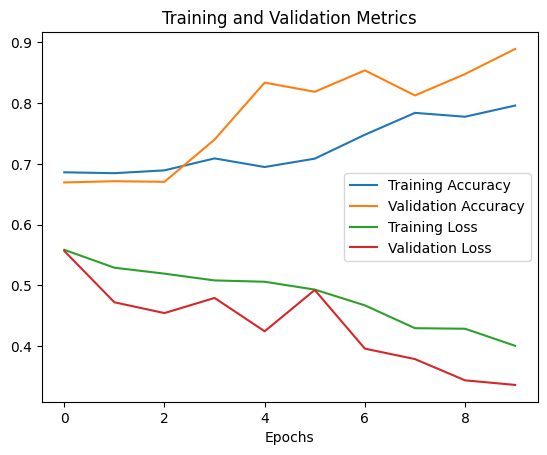

In [ ]:
# Plot training and validation metrics
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.savefig(os.path.join(save_dir, 'training_validation_metrics.png'))

32/32 [==============================] - 7s 213ms/step
Confusion Matrix:
[[460 227]
 [215 118]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       687
           1       0.34      0.35      0.35       333

    accuracy                           0.57      1020
   macro avg       0.51      0.51      0.51      1020
weighted avg       0.57      0.57      0.57      1020



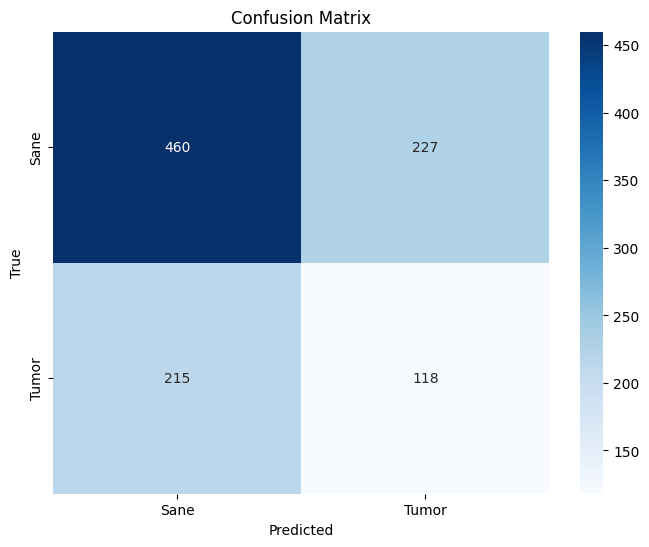

In [ ]:
# Generate confusion matrix for the test set
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
test_predictions = model.predict(test_generator,
                                 steps=test_images // batch_size + 1)
test_predictions = np.argmax(test_predictions,
                             axis=1)

# Get the true labels
test_true_labels = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_true_labels,
                               test_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=training_generator.class_indices.keys(),
            yticklabels=training_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))

# Print classification report
print("Classification Report:")
print(classification_report(test_true_labels,
                            test_predictions))

In [ ]:
# CNN SIMPLE MODEL

import pandas as pd
import numpy as np
import os
import cv2
import tensorflow
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

from timeit import default_timer as timer

In [ ]:
# Chargement des données à partir du fichier scan_info.csv
df = pd.read_csv('scan_info.csv')

# Création d'une colonne 'label' en utilisant le LabelEncoder pour convertir les classes en numériques
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['is_tumor'])

# Définition des chemins des dossiers
train_path = './train/train_scans/'
train_mask_path = './train/train_masks/'

val_path = './valid/valid_scans/'
val_mask_path = './valid/valid_masks/'

test_path = './test/test_scans/'
test_mask_path = './test/test_masks/'

In [ ]:
# Fonction pour charger les images et les masques
def load_images_and_masks(dataframe, image_path, mask_path):
    images = []
    masks = []
    labels = []

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        image_filepath = os.path.join(image_path, row['file_path'].split('scans/', 1)[-1])
        mask_filepath = os.path.join(mask_path, row['mask_path'].split('masks/', 1)[-1])

        image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Error loading images for image: {image_filepath}")
            continue

        # Redimensionnement des images
        image = cv2.resize(image, (224, 224))
        mask = cv2.resize(mask, (224, 224))

        images.append(image)
        masks.append(mask)
        labels.append(row['label'])

    return np.array(images), np.array(masks), np.array(labels)

In [ ]:
# Chargement des données d'entraînement, de validation et de test
train_images, train_masks, train_labels = load_images_and_masks(df[df['division'] == 'train'], train_path, train_mask_path)
val_images, val_masks, val_labels = load_images_and_masks(df[df['division'] == 'valid'], val_path, val_mask_path)
test_images, test_masks, test_labels = load_images_and_masks(df[df['division'] == 'test'], test_path, test_mask_path)

# Normalisation des images et masques
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

train_masks = train_masks / 255.0
val_masks = val_masks / 255.0
test_masks = test_masks / 255.0

100%|██████████| 1020/1020 [00:07<00:00, 132.76it/s]


In [ ]:
# Définition du modèle CNN
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraînement du modèle avec data augmentation
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(train_images.reshape(-1, 224, 224, 1), train_labels, batch_size=64)

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(val_images.reshape(-1, 224, 224, 1), val_labels),
                    verbose=1)

Epoch 1/30
75/75 [==============================] - 43s 414ms/step - loss: 0.6874 - accuracy: 0.6646 - val_loss: 0.6263 - val_accuracy: 0.6693
Epoch 2/30
75/75 [==============================] - 25s 328ms/step - loss: 0.6208 - accuracy: 0.6852 - val_loss: 0.6170 - val_accuracy: 0.6693
Epoch 3/30
75/75 [==============================] - 25s 329ms/step - loss: 0.6135 - accuracy: 0.6852 - val_loss: 0.6244 - val_accuracy: 0.6693
Epoch 4/30
75/75 [==============================] - 25s 334ms/step - loss: 0.6053 - accuracy: 0.6854 - val_loss: 0.6114 - val_accuracy: 0.6762
Epoch 5/30
75/75 [==============================] - 25s 328ms/step - loss: 0.5965 - accuracy: 0.6865 - val_loss: 0.5846 - val_accuracy: 0.6909
Epoch 6/30
75/75 [==============================] - 25s 334ms/step - loss: 0.5915 - accuracy: 0.6913 - val_loss: 0.6139 - val_accuracy: 0.6840
Epoch 7/30
75/75 [==============================] - 25s 335ms/step - loss: 0.5917 - accuracy: 0.6979 - val_loss: 0.5861 - val_accuracy: 0.6791

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_images.reshape(-1, 224, 224, 1), test_labels)
print(f'Test Accuracy: {test_accuracy}')

train_loss, train_accuracy = model.evaluate(train_images.reshape(-1, 224, 224, 1), train_labels)
print(f'Train Accuracy: {train_accuracy}')

# Sauvegarde du modèle
model.save('liver_disease_classifier.keras')

NameError: name 'model' is not defined

In [ ]:
def plot_metrics(history, save_path=None):
    plt.figure(figsize=(12, 8))

    # Précision
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Perte
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save_path:
        plt.savefig(os.path.join(save_path, 'metrics_plot.png'))
        plt.show()
    else:
        plt.show()


# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, classes, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')

    if save_path:
        plt.savefig(os.path.join(save_path, title))
        plt.show()
    else:
        plt.show()

In [ ]:
# Prédictions sur l'ensemble de test
test_predictions = model.predict(test_images.reshape(-1, 224, 224, 1))
test_predictions = (test_predictions > 0.5).astype(int)

train_predictions = model.predict(train_images.reshape(-1, 224, 224, 1))
train_predictions = (train_predictions > 0.5).astype(int)
# Affichage des courbes de métriques

test_loss, test_accuracy = model.evaluate(test_images.reshape(-1, 224, 224, 1), test_labels)
print(f'Test Accuracy: {test_accuracy}')


# Affichage des courbes de métriques
plot_metrics(history, save_path=r'C:\Users\yanis\OneDrive\Documents\projet_reseaux_neurones')

# Affichage de la matrice de confusion
plot_confusion_matrix(test_labels, test_predictions, classes=['Foie Sain', 'Foie Malade'], title='test_confusion_matrix.png', save_path=r'C:\Users\yanis\OneDrive\Documents\projet_reseaux_neurones')

plot_confusion_matrix(train_labels, train_predictions, classes=['Foie Sain', 'Foie Malade'], title='train_confusion_matrix.png', save_path=r'C:\Users\yanis\OneDrive\Documents\projet_reseaux_neurones')

# Rapport de classification
print("Classification Report:\n", classification_report(test_labels, test_predictions))

print("Classification Report (Training Set):\n", classification_report(train_labels, train_predictions))